# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


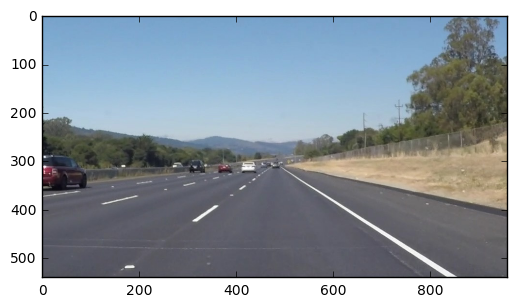

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
_ = plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold, 5) # RIC modified kernel size for opening

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with  <-- blank mask?? it is black
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return lines, line_img # RIC Modified

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg']

run your solution on all test_images and make copies into the test_images directory).

** My code starts here **

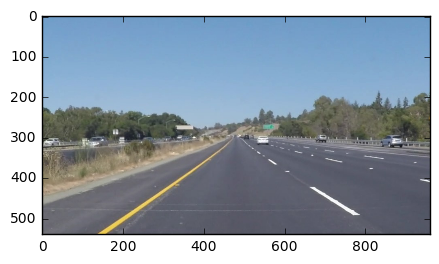

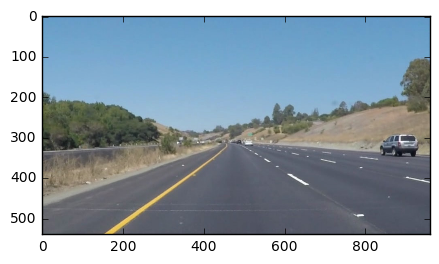

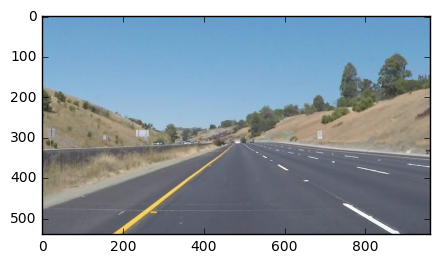

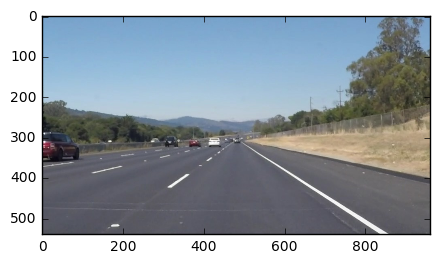

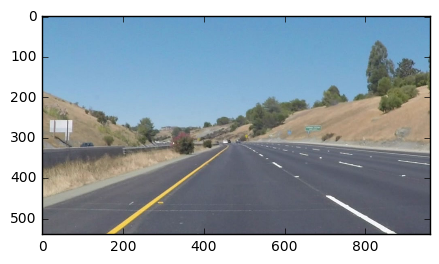

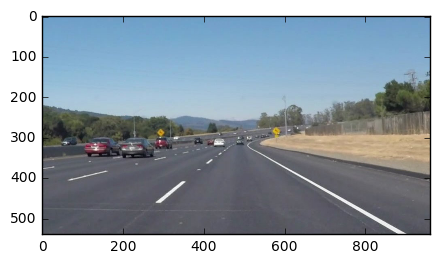

In [5]:
path2dir = "test_images/"
path2images = os.listdir(path2dir)
path2results = "res_test_images/"

# These are just a few images, load them all at once
ls_images = []

for i, path2im in enumerate(path2images):
    ls_images.append(mpimg.imread(path2dir + path2im))
    plt.figure(figsize=(5,9))
    plt.imshow(ls_images[i])

In [64]:
def consolidate_lines(img, lines):
    """"
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    """
    
    
    detected_lines = [] # List of dic with keys = m, b, length
    
    for line in lines:
        elem = {}
        elem['line'] = line[0]
        x1,y1,x2,y2 = line[0]
        elem['m'], elem['b'] = np.polyfit([x1,x2], [y1,y2], 1)
        detected_lines.append(elem)
            
    
    # Filter out those lines that are almost horizontal
    non_horizontal = []
    min_angle = np.pi/12
    
    for line in detected_lines:
        alpha = np.abs(np.arctan(line['m']))
            
        if alpha > min_angle:
            non_horizontal.append(line)
                
    # This first filter worked great. Let's continue

    # Filter out those lines that are almost vertical
    non_horizontal_vertical = []
    min_angle = np.pi/12
    
    for line in non_horizontal:
        alpha = np.abs(np.arctan(line['m'])-np.pi/2)
            
        if alpha > min_angle:
            non_horizontal_vertical.append(line)           
                
    # Filter out outliers detected in the OUTLIER ANALYSIS' section
    max_m = 1.5
    max_b = 1000
    non_outliers = []
    #if line['m'] < max_m and line['b'] < max_b:
    m1 = [-1.15274725, -0.56815511]
    m2 = [ 0.47847985,  0.73611111]
    b1 = [ 605.46377228,  796.09458128]
    b2 = [-43.98049645,  97.11263736]
    
    for line in non_horizontal_vertical:
        
        if m1[0] <= line['m'] <= m1[1]\
        or m2[0] <= line['m'] <= m2[1]:
            
            if b1[0] <= line['b'] <= b1[1]\
            or b2[0] <= line['b'] <= b2[1]:
        
                non_outliers.append(line)
    
    # Those lines that share similar slope and similar intercept term will be packed together
    # Based on CLUSTER ANALYSIS section
    
    m_th = [0.8, 0.35, -0.5, -1.1]
    right_region = []
    left_region = []
    
    for line in non_outliers:
        m = line['m']
        
        if m < m_th[0] and m > m_th[1]:
            line['region_color'] = [255, 0, 0] # Following the color convention of many headphones (L: blue, R: red)
            right_region.append(line)
        elif m < m_th[2] and m > m_th[3]:
            line['region_color'] = [0, 0, 255] 
            left_region.append(line)
    
    # Finally combine the lines in each region and extend the survival lines to the bottom 
    # of the image and shrink the lines below 320px in Y axis
    y_limits = [320, img.shape[0]]
    final_lines = []
    
    final_lines.append(join_lines(right_region, y_limits))
    final_lines.append(join_lines(left_region, y_limits))
    
    survival_lines = right_region + left_region
    
    return final_lines, survival_lines, non_horizontal_vertical

In [65]:
def join_lines(region, y_limits):
    elem = {}
    X = []
    Y = []

    if region: 
        m = [line['m'] for line in region]
        b = [line['b'] for line in region]

        m_target = np.median(m)
        b_target = np.median(b)

        '''
        for line in region:
            x1, y1, x2, y1 = line['line']
            X.append(x1)
            X.append(x2)
            Y.append(y1)
            Y.append(y2)

        m_target, b_target = np.polyfit(X, Y, 1)
        '''

        x1 = (y_limits[0]-b_target)/m_target
        x2 = (y_limits[1]-b_target)/m_target
        x1 = int(np.round(x1))
        x2 = int(np.round(x2))

        '''
        print(m_target)
        print(b_target)
        print(x1)
        print(x2)
        print(y_limits[0])
        print(y_limits[1])
        '''

        elem['line'] = [x1, y_limits[0], x2, y_limits[1]]
        elem['region_color'] = region[0]['region_color']
        
        return elem

In [103]:
def draw_lines2(img, final_lines, color=[255, 0, 0], thickness=15, fill=None, blend=True):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    # Draw the resultant image with some degree of transparency
    just_lines_img = np.zeros_like(img)
    polly = []
    
    # TODO: arreglar este try except
    for line in final_lines:
        try:
            x1,y1,x2,y2 = line['line']

            if 'region_color' in line:
                color = line['region_color']

            cv2.line(just_lines_img, (x1, y1), (x2, y2), color, thickness)

            if fill:
                polly.append((x1,y1))
                polly.append((x2,y2))
        except:
            pass
    
    if fill:
        hull = cv2.convexHull(np.asarray(polly))
        cv2.fillConvexPoly(just_lines_img, hull, color=[0,255,0]) # Fill it with green 
    
    if blend:
        final = weighted_img(just_lines_img, img, α=0.8, β=1.5, λ=0.)
    else:
        final = just_lines_img
        
    return final

In [114]:
def myprocessing_pipeline(img):
    # Convert to grayscale
    # Apply gaussian blur
    # Apply mask (ROI)
    # Compute Canny
    # Get Hough lines
    # Consolidate lines
    # Call draw_lines2
    
    imshape = img.shape
    
    gray = grayscale(img)
    
    kernel_size = 9
    blurred = gaussian_blur(gray, kernel_size)
    
    # My idea was to apply ROI before computing canny in order to reduce computation.
    # The result of this is a huge horizontal line. It can be easily removed but why complicate it at this step?
    # We will optimize later when we want to move it to production. For the moment just switch function calls.
    
    # Remember the recommendation: low/high should be similar to rate 1:2 or 1:3
    # 100 primera imagen guay. 80, 60, 20 (ruido que te cagas)
    low_th = 100
    high_th = 170 #(antes 200)
    edges = canny(blurred, low_th, high_th)
    
    # The required shape of vertices is something like this: (1, 4, 2)
    vertices = np.array([[[140, imshape[0]], [450, 320], [530, 320], [imshape[1]-40, imshape[0]]]])
    masked_edges = region_of_interest(edges, vertices)
   
    rho = 2
    theta = np.pi/180 
    threshold = 5
    min_line_len = 20 
    max_line_gap = 35 #25, 30
    lines, hough = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Let's consolidate the computed lines: filter outliers, merge candidates, and so on..
    final_lines, survival_lines, detected_lines = consolidate_lines(img, lines)
    
    # Paint something cool
    final = draw_lines2(img, final_lines, fill=True)
    
    survival = np.zeros(img.shape, dtype=np.uint8)
    survival = draw_lines2(img, survival_lines, thickness=2,blend=False)
    
    return vertices, masked_edges, hough, detected_lines, survival, survival_lines, final

In [115]:
# Create output dir
path2result = "result_test_images/"

try:
    os.mkdir(path2result)
except FileExistsError:
    pass

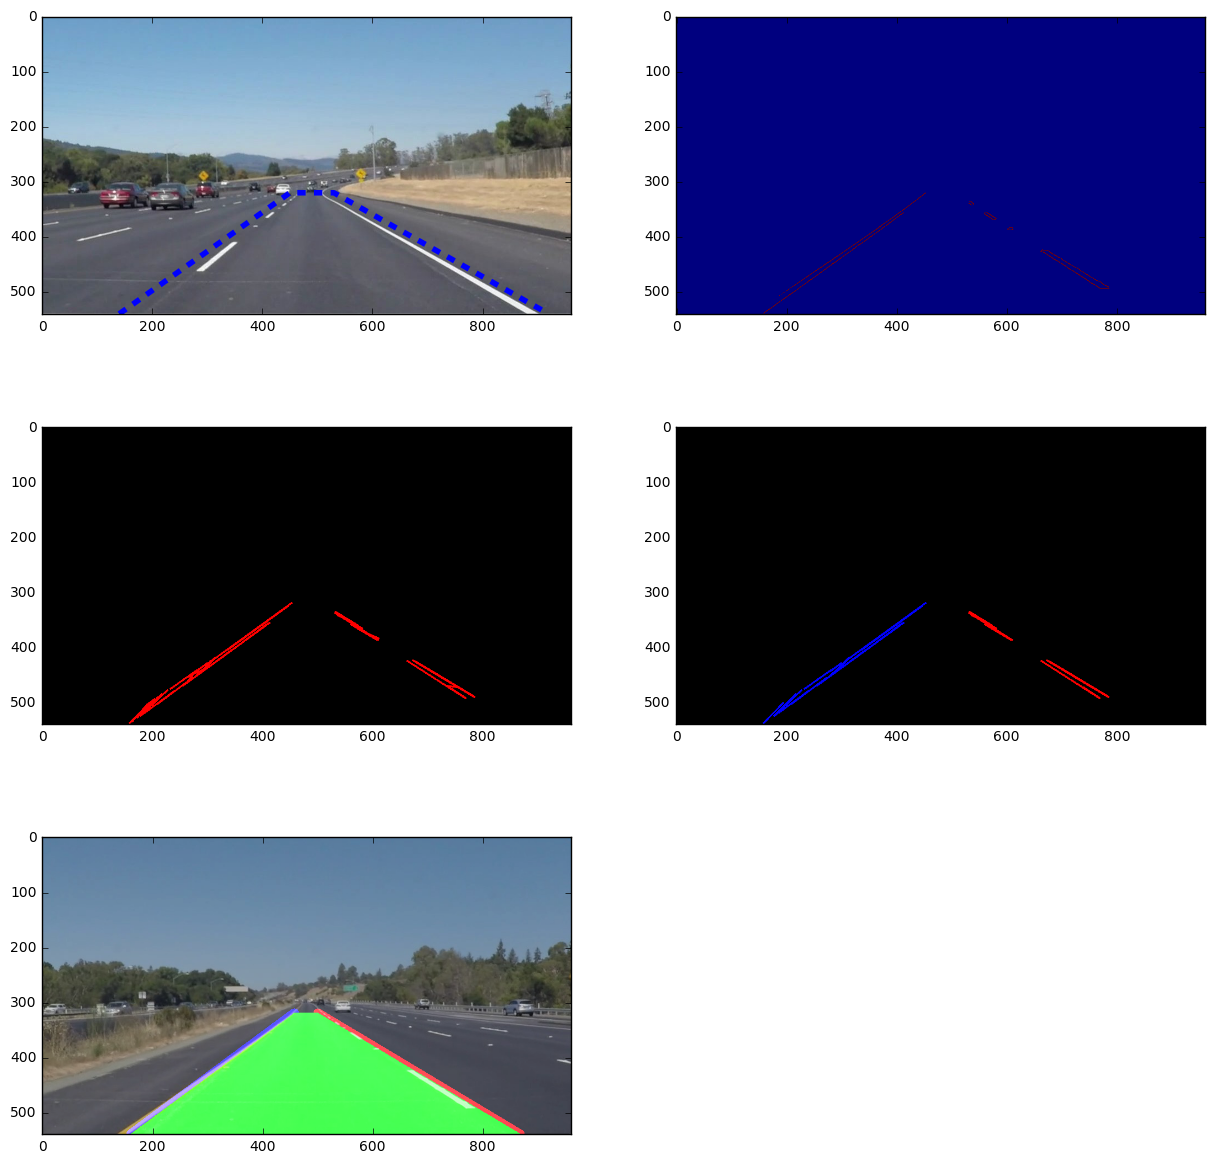

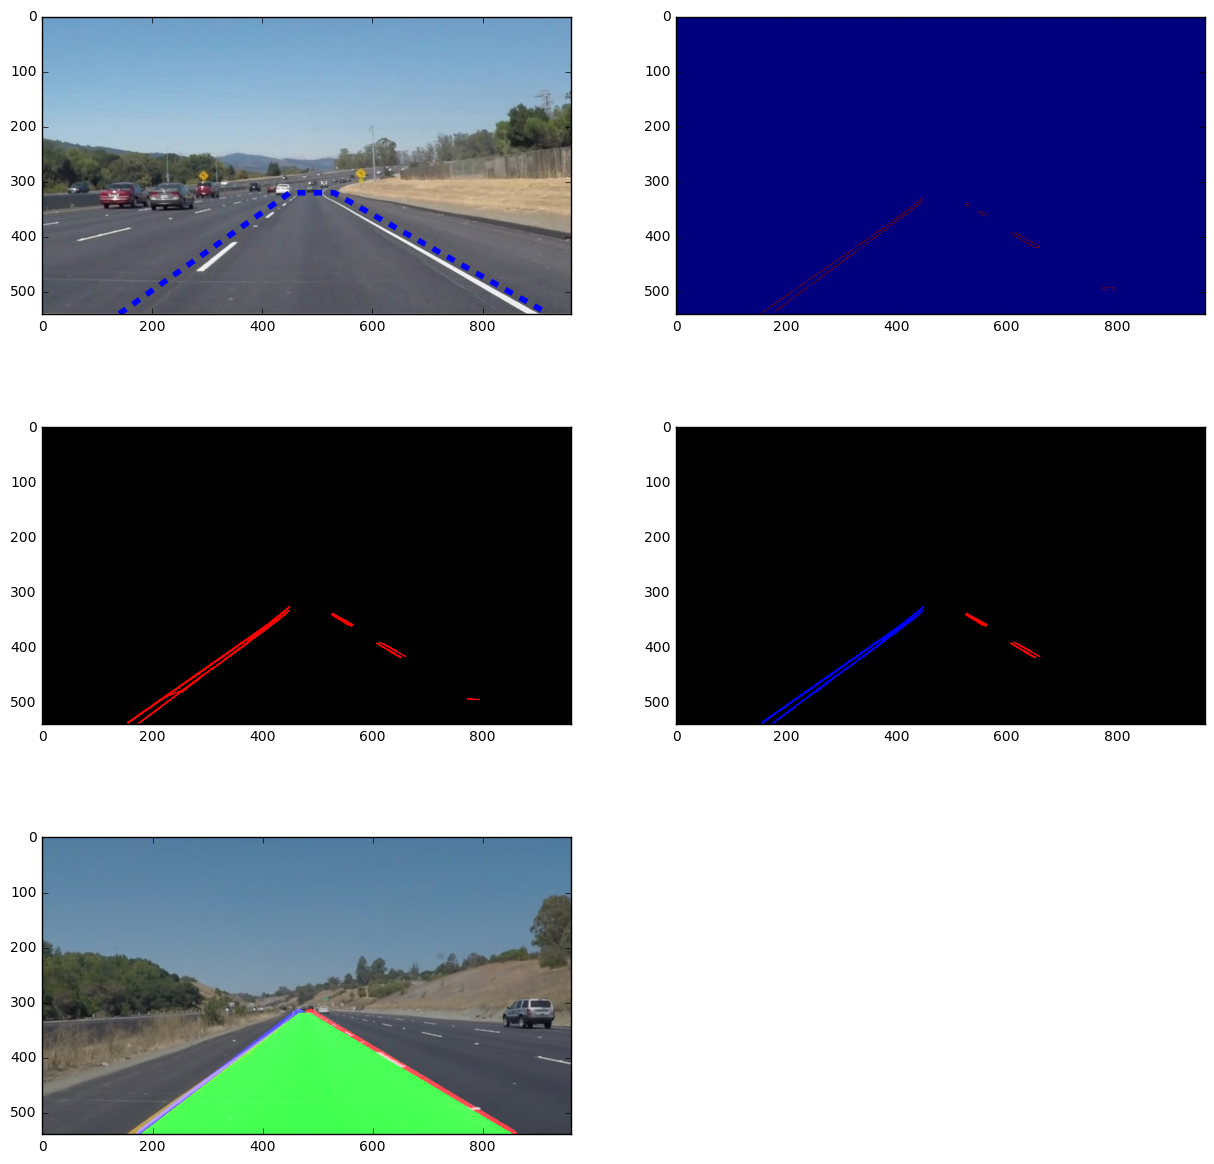

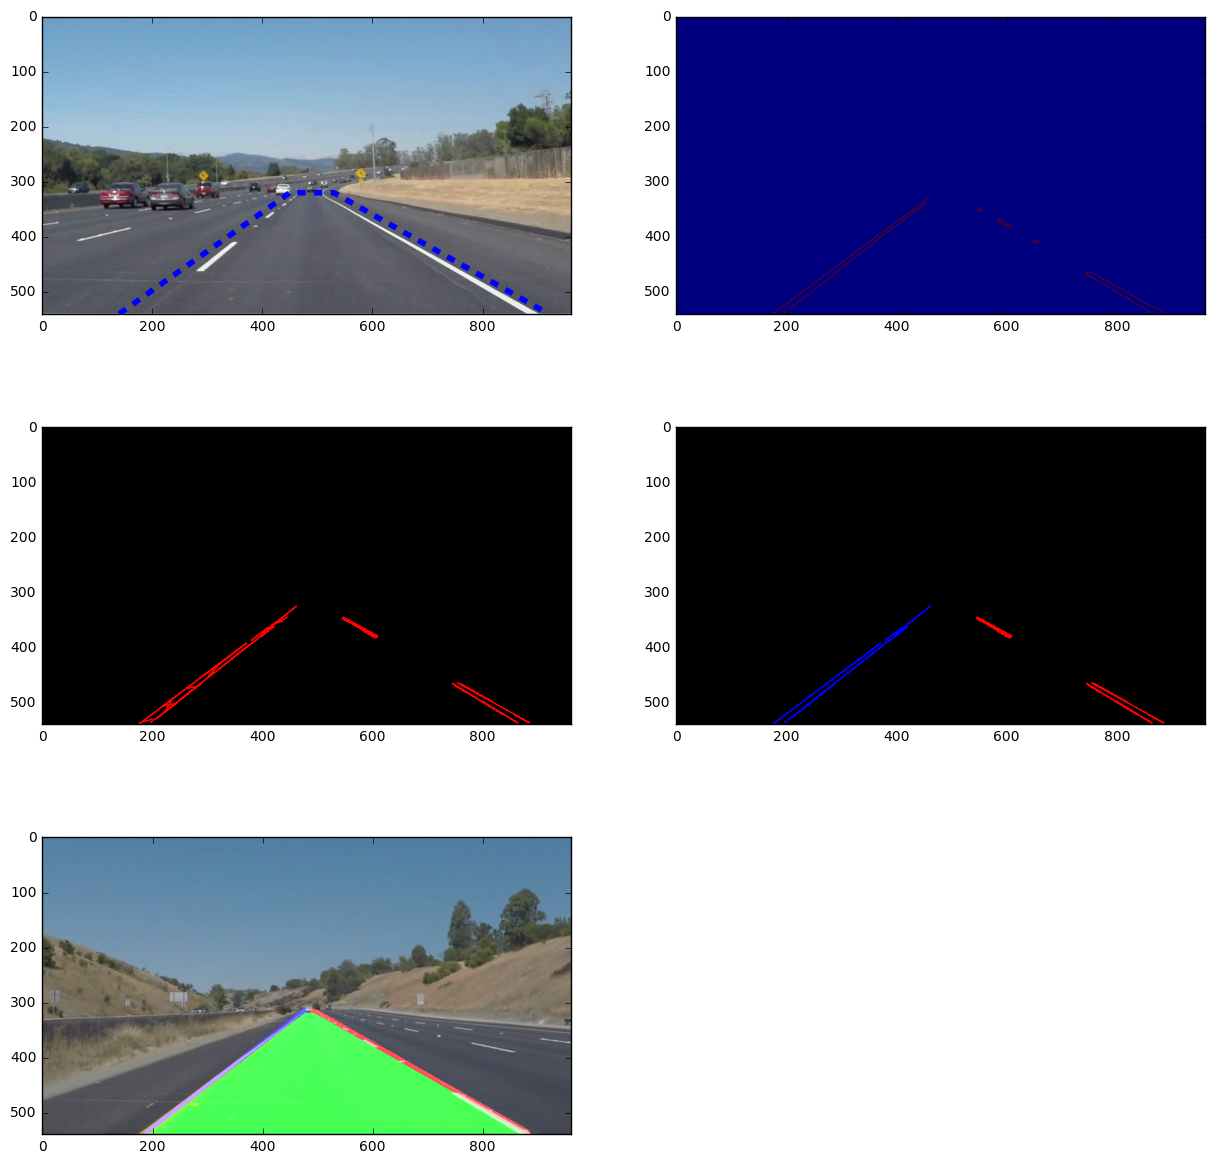

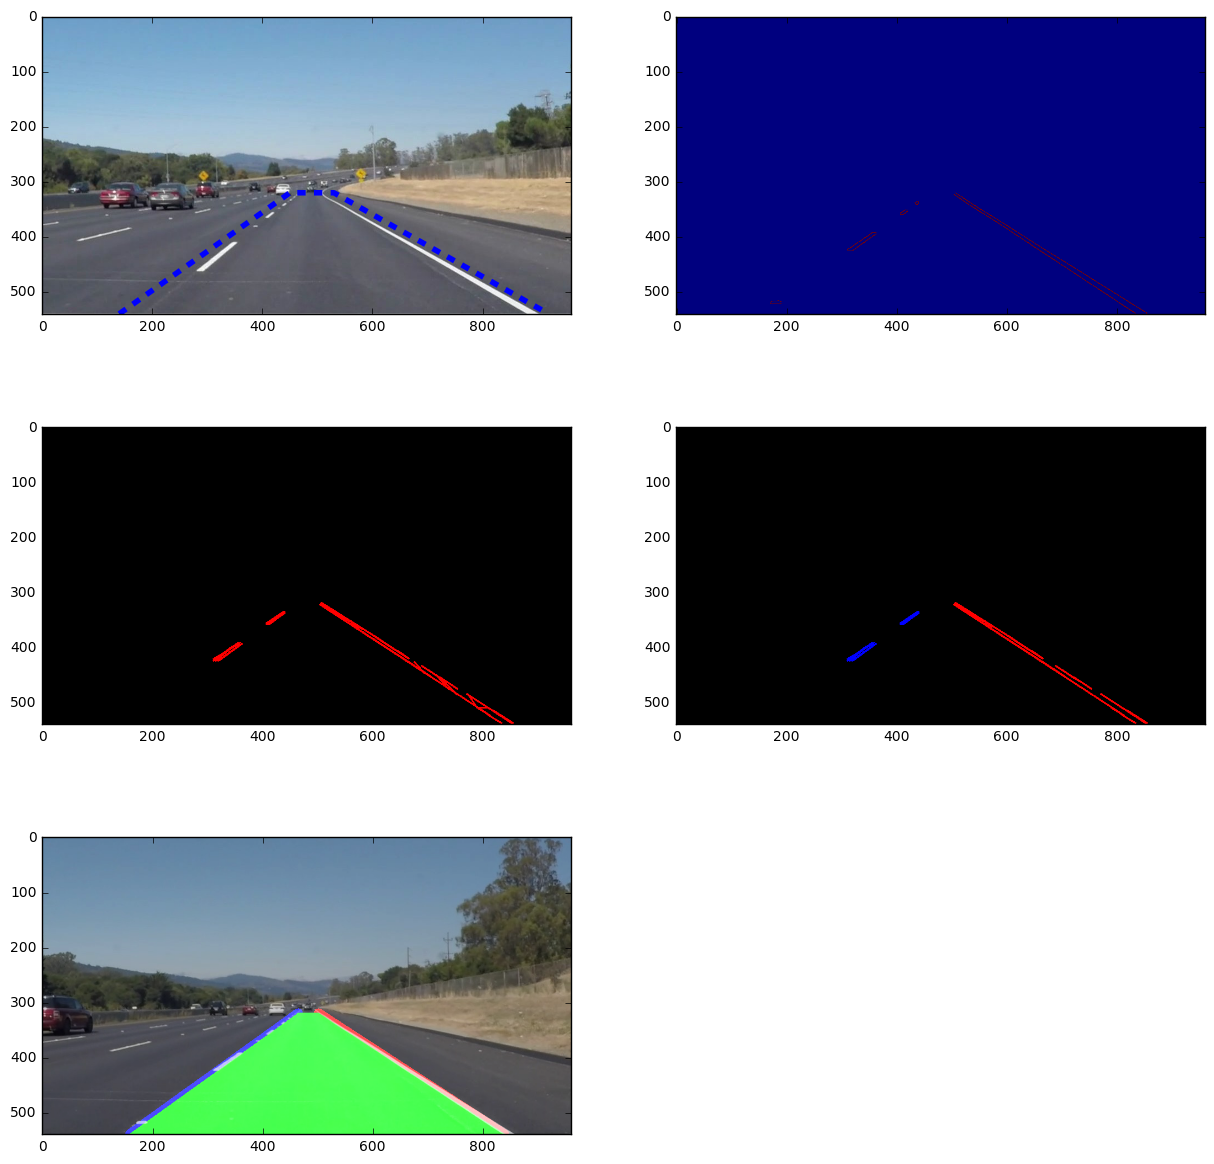

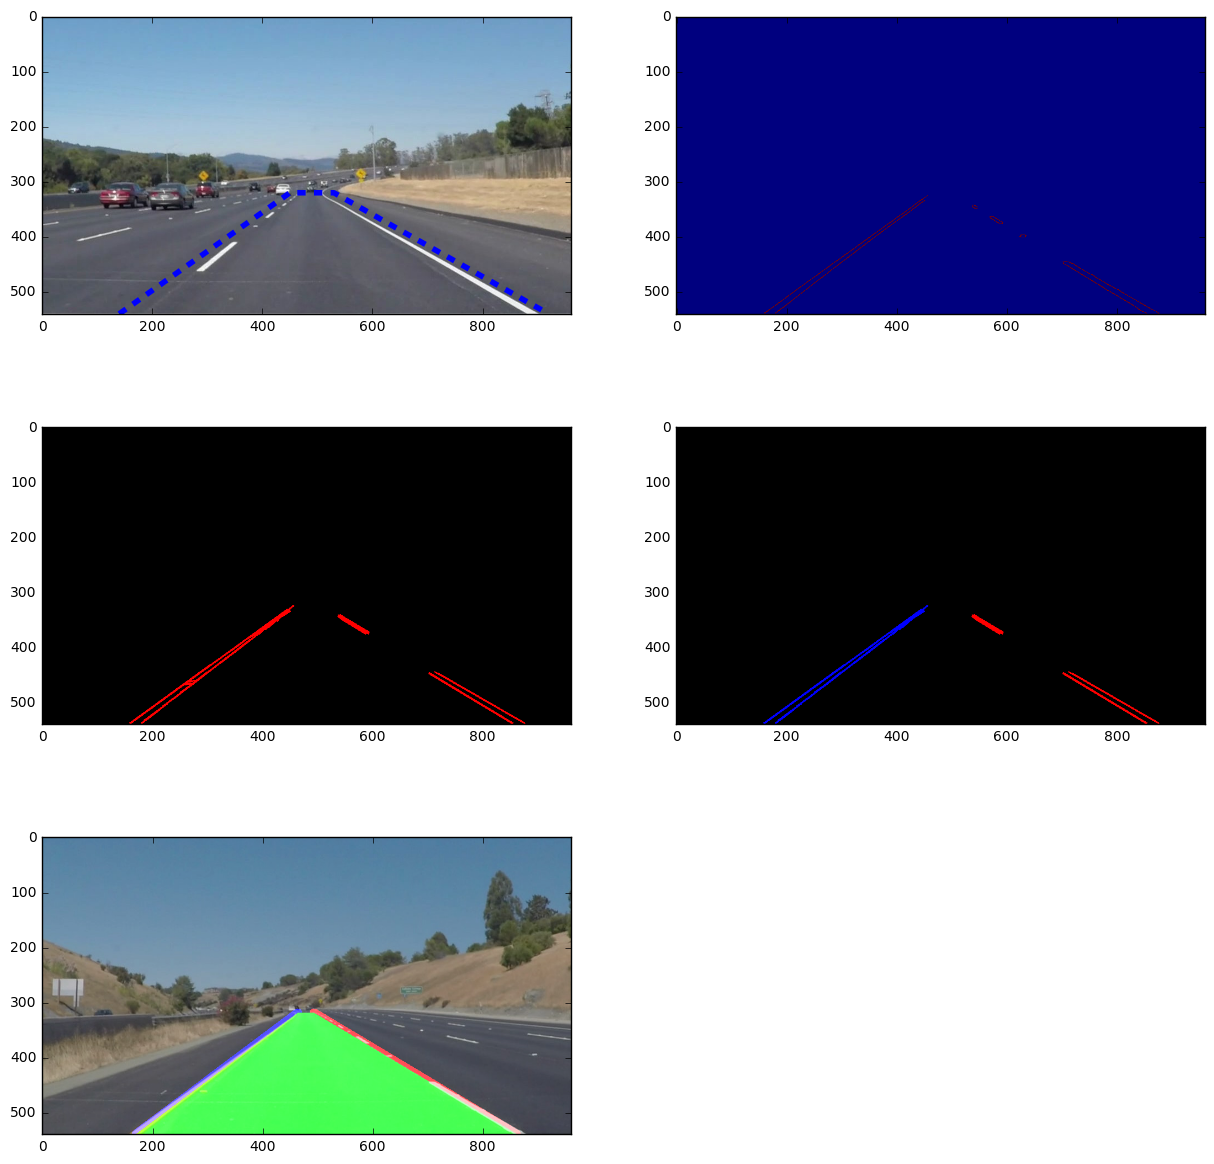

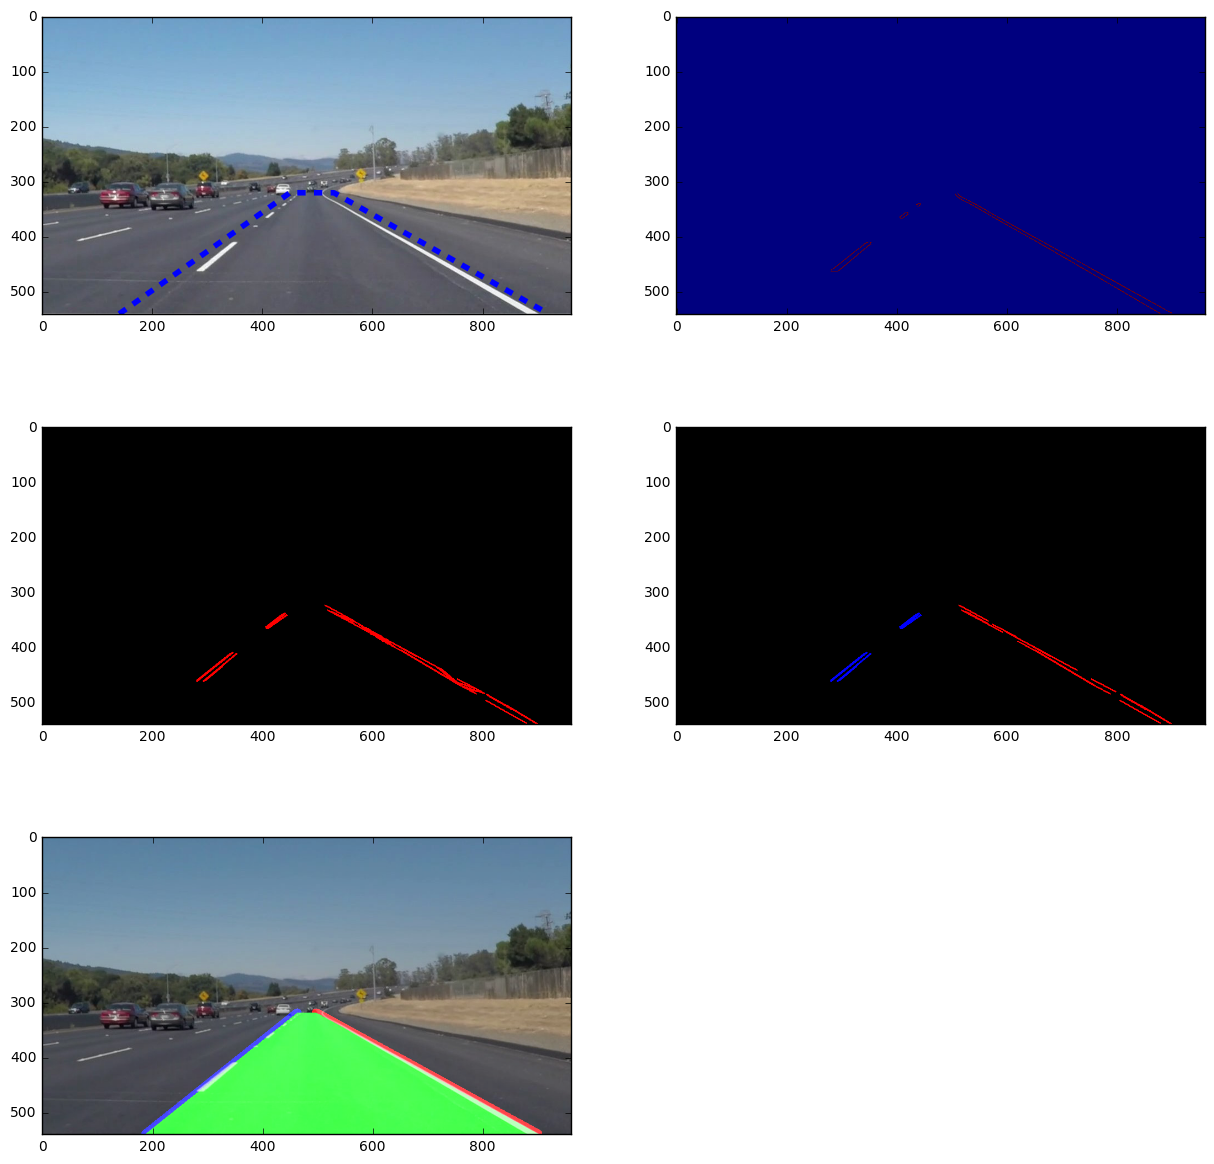

In [116]:
# Let's process the images and display the results

all_lines = []

for i, image in enumerate(ls_images):
    plt.figure(figsize=(15,15))
    
    mask_vertices, masked_edges, hough, detected_lines, survival, survival_lines, final = myprocessing_pipeline(image)

    #Masked original
    plt.subplot(321)
    plt.imshow(original)
    
    x = mask_vertices[0,:,0].tolist()
    y = mask_vertices[0,:,1].tolist()
    plt.plot(x, y, 'b--', lw=4)
    plt.ylim(image.shape[0], 0) # If the limits are not inverted the image is shown flipped
    plt.xlim(0, image.shape[1])
    
    # Masked dges
    plt.subplot(322)
    plt.imshow(masked_edges)
    
    # Hough
    plt.subplot(323)
    plt.imshow(hough)
    
    # Survival
    plt.subplot(324)
    plt.imshow(survival)
    
    # Final
    plt.subplot(325)
    plt.imshow(final) 
    
    
    # Write results
    mpimg.imsave(path2result + "res" + path2images[i], final)
    
    # Store all detected lines for debuging purposes
    all_lines.append(detected_lines)

# Outlier analysis

In [ ]:
STOP HERE (Avoid execution of unwanted cells)

In [76]:
all_lines_flat = [item for sublist in all_lines for item in sublist] # Flattened list of lists

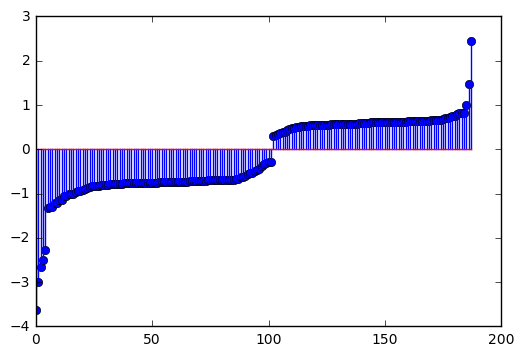

In [56]:
# Let's filter out those strange m
m = np.array([line['m'] for line in all_lines_flat])
_ = plt.stem(np.sort(m))

In [58]:
np.percentile(m[m>0], [5, 95])

array([ 0.4       ,  0.81381381])

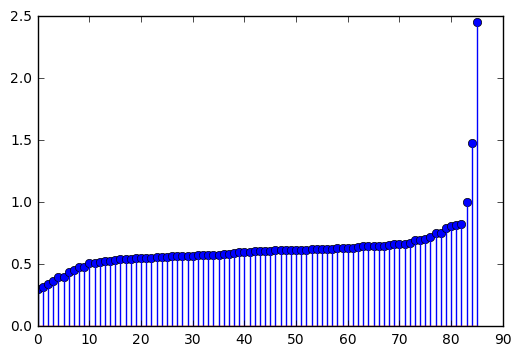

In [34]:
_ = plt.stem(np.sort(m[m>0]))

In [59]:
np.percentile(m[m<0], [5, 95])

array([-1.33137255, -0.43879573])

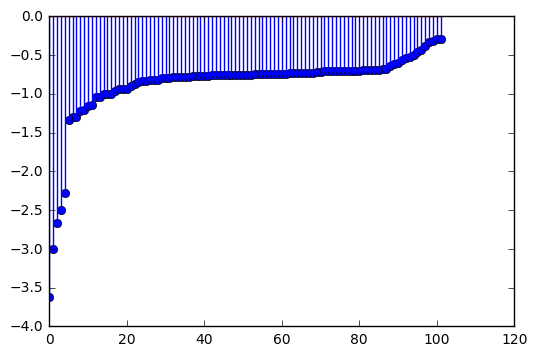

In [36]:
_ = plt.stem(np.sort(m[m<0]))

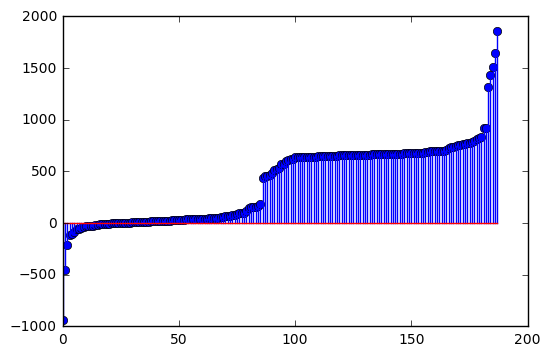

In [37]:
# Let's filter out strange b
b = np.array([line['b'] for line in all_lines_flat])
_ = plt.stem(np.sort(b))

In [61]:
np.percentile(b[b>400], [10, 90])

array([ 605.46377228,  796.09458128])

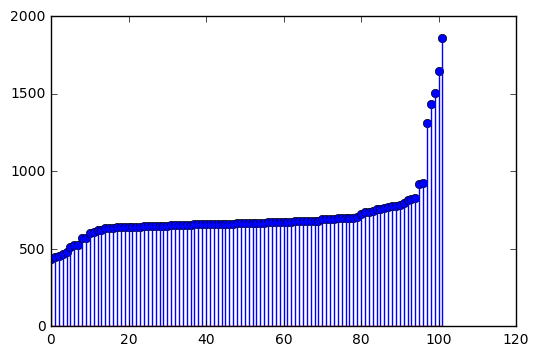

In [39]:
_ = plt.stem(np.sort(b[b>400]))

In [63]:
np.percentile(b[b<400], [10, 90])

array([-43.98049645,  97.11263736])

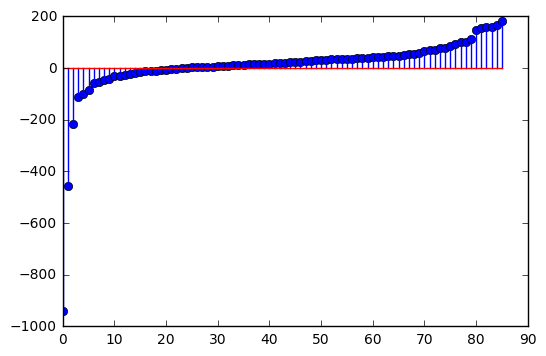

In [41]:
_ = plt.stem(np.sort(b[b<400]))

# Cluster analysis

In [ ]:
STOP HERE (Avoid execution of unwanted cells)

In [138]:
all_lines_flat = [item for sublist in all_lines for item in sublist] # Flattened list of lists
m = [line['m'] for line in all_lines_flat]
b = [line['b'] for line in all_lines_flat]

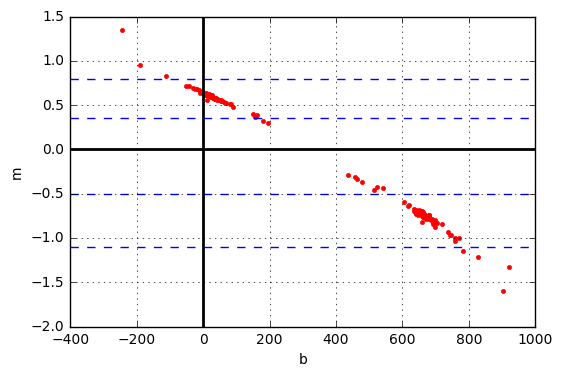

In [146]:
y = m
x = b
_ = plt.plot(x,y, 'r.')
plt.grid(True)
plt.axhline(0, color='black', lw=2)
plt.axvline(0, color='black', lw=2)
_ = plt.ylabel("m")
_ = plt.xlabel("b")
_ = plt.axhline(0.8, color='blue', ls='dashed')
_ = plt.axhline(0.35, color='blue', ls='dashed')
_ = plt.axhline(-0.5, color='blue', ls='dashed')
_ = plt.axhline(-1.1, color='blue', ls='dashed')

In [212]:
# There are 2 big regions tha concentrate the most of the points: 
# 0.35<m<0.8
# -0.5<m<-1.1

# The final m can be computed as the mean, as all the point fall in a small range. However, b has a huge range. Let's
# see what can we do

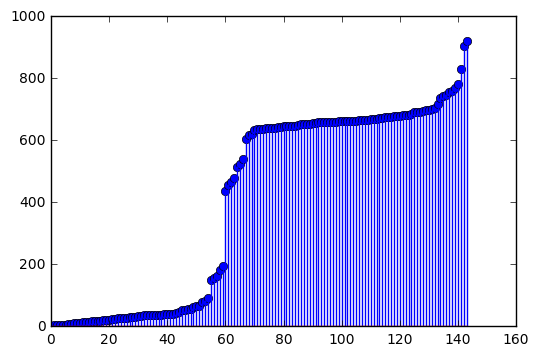

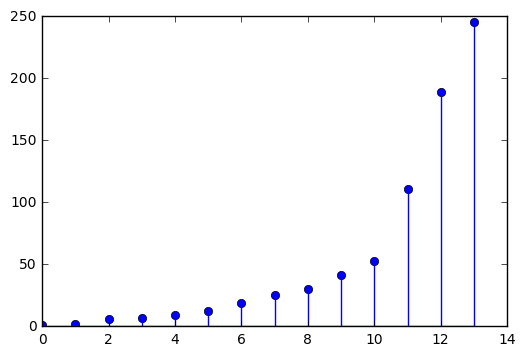

In [147]:
b_pos = [elem for elem in b if elem>0]
plt.figure()
_ = plt.stem(np.sort(b_pos))
b_neg = [elem for elem in b if elem<0]
plt.figure()
_ = plt.stem(np.sort(np.abs(b_neg)))

In [148]:
print(np.median(b_pos))
print(np.median(np.abs(b_neg)))

635.952807646
22.187187642


# Crazy exploration: please, ignore until /Crazy exploration tag

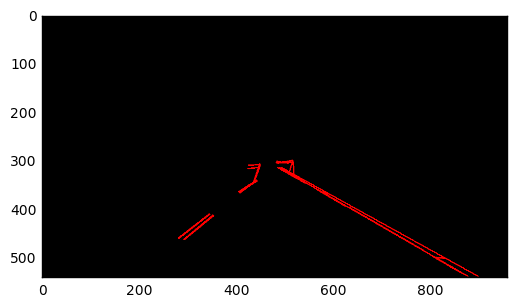

In [12]:
plt.imshow(hough)

# Idea:
# Gray and binarize
# Dilate + Erode
# Hough again
# Paint the result


In [13]:
hough.shape

(540, 960, 3)

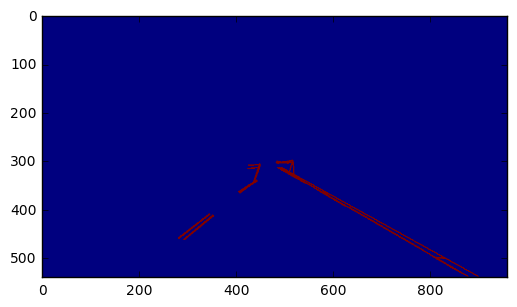

In [15]:
plt.imshow(hough[:,:,0])

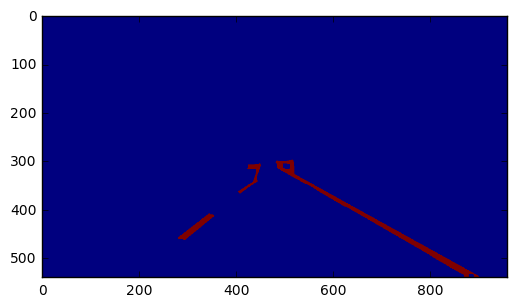

In [45]:
kernel = np.ones((5,5),np.uint8)
closing = cv2.morphologyEx(hough[:,:,0], cv2.MORPH_CLOSE, kernel, iterations = 2)

plt.imshow(closing)

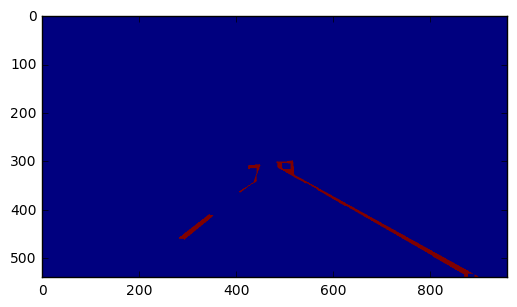

In [48]:
kernel2 = np.ones((3,3), np.uint8)
erode = cv2.erode(closing, kernel2)
plt.imshow(erode)

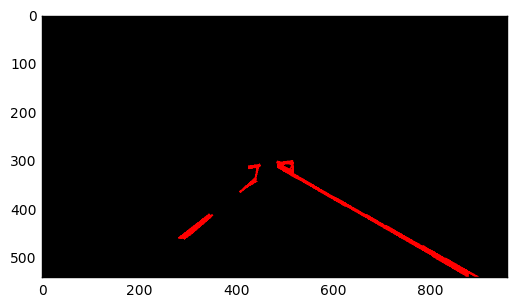

In [49]:
rho = 2
theta = np.pi/180 
threshold = 10
min_line_len = 20 
max_line_gap = 25
    

lines, hough2 = hough_lines(erode, rho, theta, threshold, min_line_len, max_line_gap)
plt.imshow(hough2)

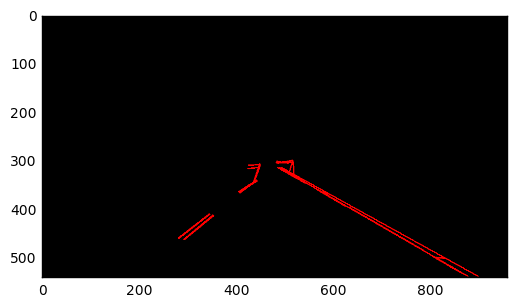

In [31]:
plt.imshow(hough)

In [50]:
# Doesn't help too much and probably it's computationally intensive. Doesn't pay off

# /Crazy exploration

In [ ]:
# My code finish here

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [107]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [121]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    _, _, _, _, _, _, result = myprocessing_pipeline(image)

    return result

Let's try the one with the solid white lane on the right first ...

In [117]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white2.mp4
[MoviePy] Writing video white2.mp4


100%|█████████▉| 221/222 [00:11<00:00, 17.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white2.mp4 

CPU times: user 12.3 s, sys: 643 ms, total: 13 s
Wall time: 12 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [118]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [119]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow2.mp4
[MoviePy] Writing video yellow2.mp4


100%|█████████▉| 681/682 [00:37<00:00, 16.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow2.mp4 

CPU times: user 39.8 s, sys: 2.06 s, total: 41.8 s
Wall time: 38.2 s


In [120]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


I realized that are many outliers that make my final lines move away a bit, even using robust estimators such as median. I think there can be two extra things that will improve it greatly: 
1- Computing the final line not using all points equally but giving weights to them. Those that have more white/yellow in the surroundings will have more weight.
2- Use time smoothing. A line in intant T should considered the previous line: l_final(T) = α*l_estimated(T) + β*l(T-1)

My current algorithm will fail when the lightning conditions don't allow the lines to be over the threshold, e.g. at dusk (my experience tell me that dusk is always a problem), night, etc. Also at night the lights of my car and the other cars will create regions with high gradient (the thresholds of the beams) that will make this algorithm fail. It will face troubles with curves, in high congestion scenarios, etc.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [194]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:29<00:00,  7.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 32.4 s, sys: 1.8 s, total: 34.2 s
Wall time: 31.6 s


In [195]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))